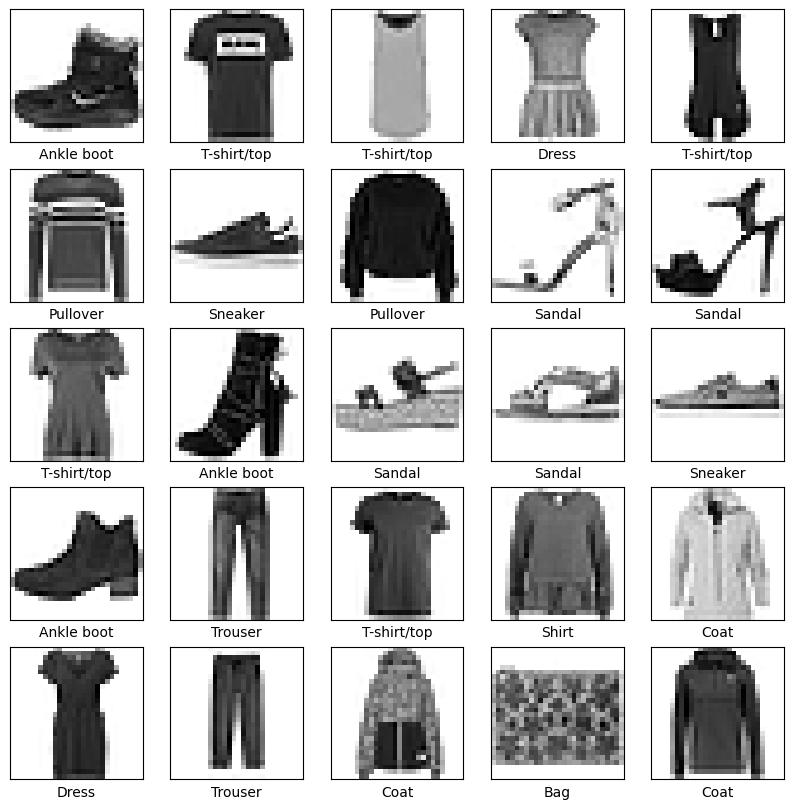

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.layers import (
    Dense,
    Input,
    Add,
    Activation,
    BatchNormalization,
    Dropout,
)
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD
from keras import regularizers

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Flatten the images for DNN
x_train_flat = x_train.reshape(-1, 28 * 28)
x_test_flat = x_test.reshape(-1, 28 * 28)

# Visualize some samples
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(y_train[i])])
plt.show()

In [ ]:
# 2 layers per residual block
def residual_block(x, units):
    shortcut = x
    if x.shape[-1] != units:
        shortcut = Dense(units, kernel_regularizer=regularizers.l2(0.001))(shortcut)

    x = Dense(units, kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.8)(x)

    x = Dense(units, kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

# 11 layers total
def create_resnet_dnn():
    inputs = Input(shape=(784,))

    x = BatchNormalization()(inputs)

    x = Dense(1024, kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = residual_block(x, 512)

    x = Dense(256, kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)

    x = residual_block(x, 256)

    x = Dense(128, kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = residual_block(x, 128)
    x = Dropout(0.4)(x)

    outputs = Dense(10, activation="softmax")(x)

    return Model(inputs, outputs)


resnet_model = create_resnet_dnn()

In [ ]:
resnet_model = create_resnet_dnn()
resnet_model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
resnet_history = resnet_model.fit(
    x_train_flat,
    y_train,
    validation_split=0.15,
    batch_size=128,
    epochs=40,
    callbacks=[
        EarlyStopping(
            patience=15,
            restore_best_weights=True,
            monitor="val_accuracy",
            min_delta=0.001,
        ),
        ReduceLROnPlateau(
            patience=5, factor=0.5, min_lr=1e-6, monitor="val_accuracy", verbose=1
        ),
    ],
    verbose=1,
)

Epoch 1/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 47s 98ms/step - accuracy: 0.3296 - loss: 6.1197 - val_accuracy: 0.7146 - val_loss: 4.3151 - learning_rate: 0.0100
Epoch 2/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.6882 - loss: 4.2314 - val_accuracy: 0.7750 - val_loss: 3.6286 - learning_rate: 0.0100
Epoch 3/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.7680 - loss: 3.5676 - val_accuracy: 0.8311 - val_loss: 3.0807 - learning_rate: 0.0100
Epoch 4/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - accuracy: 0.8134 - loss: 3.0576 - val_accuracy: 0.8566 - val_loss: 2.6536 - learning_rate: 0.0100
Epoch 5/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - accuracy: 0.8429 - loss: 2.6320 - val_accuracy: 0.8633 - val_loss: 2.3106 - learning_rate: 0.0100
Epoch 6/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 39s 84ms/step - accuracy: 0.8546 - loss: 2.2863 - val_accuracy: 0.8681 - val_loss: 2.0351 - learning_rate: 0.0100
Epoch 7/40
399/399 ━━━━━━━━━━━━━━━━━━━━ 42s 88ms/step - accuracy: 0.8676 - l

In [ ]:
# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

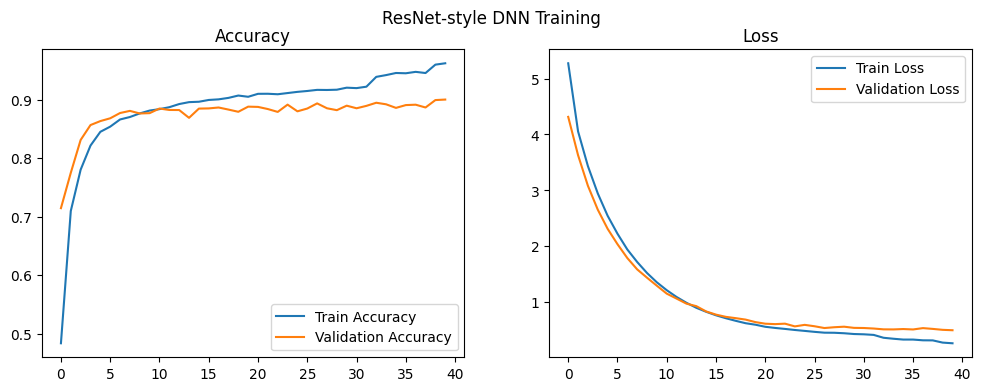

In [ ]:
plot_history(resnet_history, "ResNet-style DNN Training")

In [ ]:
# Evaluate on test set
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(
    x_test_flat, y_test, verbose=0
)

In [ ]:
print(f"ResNet-style DNN Test Accuracy: {resnet_test_acc:.4f}")

ResNet-style DNN Test Accuracy: 0.8976



ResNet-style DNN Predictions:
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


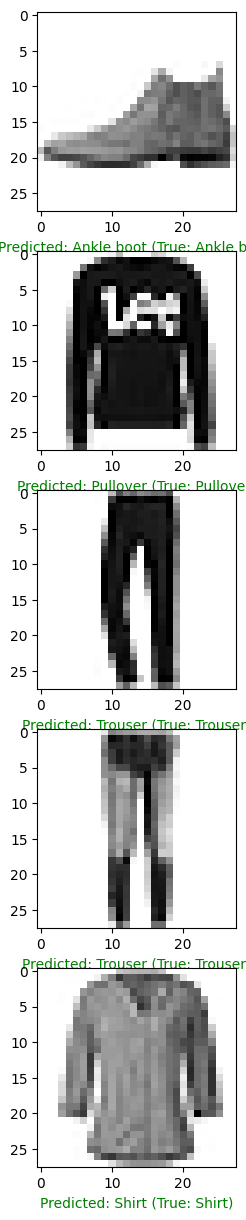

In [ ]:
# Make predictions and visualize some results
def plot_predictions(model, x_test, y_test, num_images=5):
    predictions = model.predict(x_test)
    plt.figure(figsize=(15, 3 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.binary)
        pred_label = np.argmax(predictions[i])
        true_label = np.argmax(y_test[i])
        color = "green" if pred_label == true_label else "red"
        plt.xlabel(
            f"Predicted: {class_names[pred_label]} (True: {class_names[true_label]})",
            color=color,
        )
    plt.show()


print("\nResNet-style DNN Predictions:")
plot_predictions(resnet_model, x_test_flat, y_test)